In [1]:
#Import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
milk_data = pd.read_csv('monthly-milk-production.csv',index_col='Month')

In [3]:
milk_data.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
#To make the index a time series
milk_data.index = pd.to_datetime(milk_data.index)

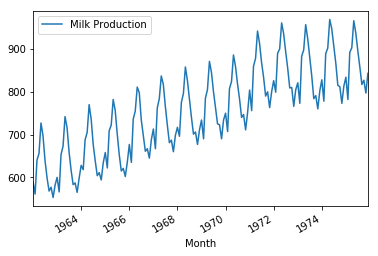

In [5]:
milk_data.plot()

In [6]:
milk_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [7]:
train_set = milk_data.head(156)
test_set = milk_data.tail(12)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [9]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

Setting Up The RNN Model

In [10]:
import tensorflow as tf

C:\Users\imroy\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate 
learning_rate = 0.001
# how many iterations to go through (training steps)
num_train_iterations = 6000
# Size of the batch of data
batch_size = 1

In [12]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [13]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


In [14]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [15]:
#Loss function
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [16]:
init = tf.global_variables_initializer()

In [17]:
saver = tf.train.Saver()

In [ ]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./time_series_model_milk_production")

0 	MSE: 0.08041294
100 	MSE: 0.04149287
200 	MSE: 0.039562497
300 	MSE: 0.052499462
400 	MSE: 0.017118504
500 	MSE: 0.009435607
600 	MSE: 0.015134745
700 	MSE: 0.008492741
800 	MSE: 0.010759779
900 	MSE: 0.008413431
1000 	MSE: 0.010967397
1100 	MSE: 0.0099558
1200 	MSE: 0.008759971
1300 	MSE: 0.007971985
1400 	MSE: 0.009191711
1500 	MSE: 0.009889583
1600 	MSE: 0.00555413
1700 	MSE: 0.006731085
1800 	MSE: 0.005779738
1900 	MSE: 0.009525703
2000 	MSE: 0.0071091154
2100 	MSE: 0.0054887594
2200 	MSE: 0.008966613
2300 	MSE: 0.007000864
2400 	MSE: 0.0073701367
2500 	MSE: 0.002402862
2600 	MSE: 0.0044501806
2700 	MSE: 0.0056231436


In [ ]:
test_set

In [ ]:
with tf.Session() as sess:
    
    #Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./time_series_model_milk_production")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data.
    train_seed = list(train_scaled[-12:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

In [ ]:
train_seed

In [ ]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [ ]:
test_set['Generated'] = results

In [ ]:
test_set


In [ ]:
test_set.plot()